## 11.1 gradient vanishing & exploding

### 11.1.1 글로렛, He 초기화

- 글로렛 초기화 : 하이퍼 볼릭 탄젠트, 로지스틱, 소프트맥스

- He 초기화 : ReLU와 친구들

- 르쿤 : SELU

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [2]:
keras.layers.Dense(10, activation='relu') # 기본적으로 균등분포 글로렛 초기화
keras.layers.Dense(10, activation='relu',kernel_initializer='he_normal') # He 초기화

In [3]:
# fanin 대신 fanavg 기반 균등분포 He 초기화
he_avg_init = keras.initializers.VarianceScaling(scale=2.,mode='fan_avg',distribution='uniform')

keras.layers.Dense(10, activation='sigmoid',kernel_initializer=he_avg_init)

### 11.1.2 수렴하지 않는 활성화 함수

- ReLU : 특정 양수에 수렴하지 않는다. 빠르다. / 0 이하의 값이 죽는다.

- LeakyReLU : $\alpha$ 값으로 조정. 0 이하의 값도 나타난다. $\alpha$ = 0.2가 0.01 보다 좋았다.

- RReLU : 훈련시 $\alpha$값을 무작위로 선택, 테스트시 평균 $\alpha$를 사용

- PReLU : $\alpha$ 값도 역전파를 이용하여 학습한다.

- ELU : ReLU 계열의 어떤 함수보다 결과가 좋았다. 학습속도(수렴속도)가 빠르다. / 계산속도가 느려 테스트시 오랜 시간이 걸린다.

- SELU : 자기 정규화가 이루어진다. 뛰어나다. / 완전 연결층에서 의미가 있다. 순환신경망, 중간 연결등에서는 자기 정규화를 보장하지 못한다.  

결론: 아래쪽으로 갈 수록 발전한(성능좋은) 함수이다. 많은 프레임워크들이 ReLU에 최적화 되어있어 속도면에서 ReLU가 빠르다.

### 11.1.3 배치 정규화
- 평균 = 0 , 분산 = 1로 입력 값을 정규화한다.

- 기울기 소실, 발산 문제를 방지한다.

- 규제의 필요성을 줄여준다.

- 성능을 높여준다.(ex. 이미지넷)

In [4]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28])
    ,keras.layers.BatchNormalization()
    ,keras.layers.Dense(300,activation='elu',kernel_initializer='he_normal')
    ,keras.layers.BatchNormalization()
    ,keras.layers.Dense(100,activation='elu',kernel_initializer='he_normal')
    ,keras.layers.BatchNormalization()
    ,keras.layers.Dense(10,activation='softmax')
])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1

In [6]:
[(var.name,var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [7]:
# 활성화 함수 전에 BN 적용하기
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28])
    ,keras.layers.BatchNormalization()
    ,keras.layers.Dense(300,kernel_initializer='he_normal',use_bias=False)
    ,keras.layers.BatchNormalization()
    ,keras.layers.Activation('elu')
    ,keras.layers.Dense(100,kernel_initializer='he_normal',use_bias=False)
    ,keras.layers.BatchNormalization()
    ,keras.layers.Activation('elu')
    ,keras.layers.Dense(10,activation='softmax')
])

### 11.1.4 그래디언트 클리핑

- 기울기 발산 문제를 해결

- 순환 신경망에서 BN을 적용하기 어려워사용, 다른 네트워크에서는 BN이면 충분하다.

- 편미분 값을 -1.0 ~ 1.0 사이로 클리핑,

    - 값을 클리핑(clipvalue) : [0.9, 100.0] -> [0.9, 1.0] : 벡터의 방향이 바뀐다.
    - 방향을 유지한 클리핑(clipnorm) : [0.9,100.0] -> [0.0089, 0.9999] : 방향은 유지되지만 첫 값이 거의 무시된다.

## 11.2 사전에 학습된 층 재사용하기(전이학습)

### 11.2.1 케라스를 이용한 전이학습

In [11]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

4423680/4422102 [==============================] - 1s 0us/step


In [12]:
tf.random.set_seed(42)
np.random.seed(42)

In [13]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [14]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [15]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 33s 24ms/step - loss: 0.5926 - accuracy: 0.8104 - val_loss: 0.3896 - val_accuracy: 0.8662
Epoch 2/20
1375/1375 [==============================] - 32s 23ms/step - loss: 0.3523 - accuracy: 0.8785 - val_loss: 0.3288 - val_accuracy: 0.8824
Epoch 3/20
1375/1375 [==============================] - 32s 23ms/step - loss: 0.3171 - accuracy: 0.8896 - val_loss: 0.3014 - val_accuracy: 0.8986
Epoch 4/20
1375/1375 [==============================] - 32s 23ms/step - loss: 0.2973 - accuracy: 0.8974 - val_loss: 0.2896 - val_accuracy: 0.9016
Epoch 5/20
1375/1375 [==============================] - 34s 25ms/step - loss: 0.2835 - accuracy: 0.9020 - val_loss: 0.2775 - val_accuracy: 0.9061
Epoch 6/20
1375/1375 [==============================] - 38s 28ms/step - loss: 0.2730 - accuracy: 0.9062 - val_loss: 0.2734 - val_accuracy: 0.9068
Epoch 7/20
1375/1375 [==============================] - 43s 31ms/step - loss: 0.2641 - accuracy: 0.9093 - val_loss: 0.2720 -

In [16]:
model_A.save("my_model_A.h5")

In [19]:
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1,activation='sigmoid')) 

In [22]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [24]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss='binary_crossentropy',optimizer='sgd',metrics=['accuracy'])
    

In [ ]:
import pandas as pd
df = pd.DataFrame(history.history)

<IPython.core.display.Javascript object>


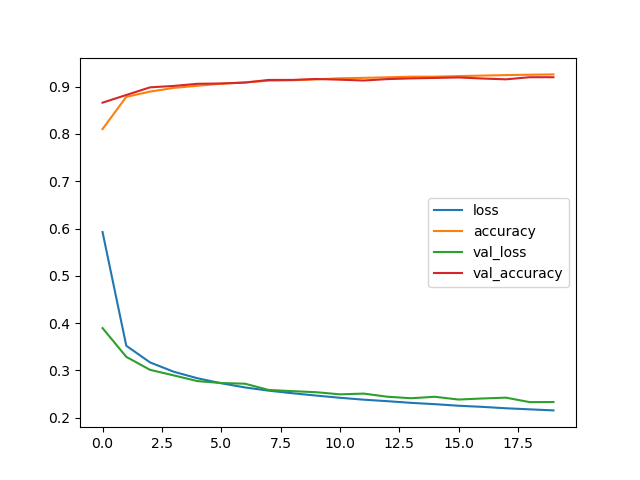

<AxesSubplot:>

In [32]:
%matplotlib notebook
df.plot()

In [35]:
history = model_B_on_A.fit(X_train_B,y_train_B,epochs=4,validation_data=(X_valid_B,y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True
    
optimizer = keras.optimizers.SGD(lr=1e-4)
model_B_on_A.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

history = model_B_on_A.fit(X_train_B,y_train_B,epochs=16,validation_data=(X_valid_B,y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 80ms/step - loss: 0.0738 - accuracy: 0.9850 - val_loss: 0.0925 - val_accuracy: 0.9817
Epoch 2/4
7/7 [==============================] - 0s 64ms/step - loss: 0.0670 - accuracy: 0.9850 - val_loss: 0.0864 - val_accuracy: 0.9838
Epoch 3/4
7/7 [==============================] - 0s 65ms/step - loss: 0.0620 - accuracy: 0.9850 - val_loss: 0.0812 - val_accuracy: 0.9848
Epoch 4/4
7/7 [==============================] - 0s 61ms/step - loss: 0.0577 - accuracy: 0.9850 - val_loss: 0.0768 - val_accuracy: 0.9858
Epoch 1/16
7/7 [==============================] - 1s 161ms/step - loss: 0.0551 - accuracy: 0.9850 - val_loss: 0.0762 - val_accuracy: 0.9858
Epoch 2/16
7/7 [==============================] - 1s 72ms/step - loss: 0.0546 - accuracy: 0.9850 - val_loss: 0.0757 - val_accuracy: 0.9868
Epoch 3/16
7/7 [==============================] - 0s 64ms/step - loss: 0.0542 - accuracy: 0.9850 - val_loss: 0.0752 - val_accuracy: 0.9868
Epoch 4/16
7/7 [==============

결과가 좋지만 믿어서는 안된다. 전이학습은 얕은 완전연결 모델에서는 잘 작동하지 않는다.  
대부분의 논문 결과를 믿어서는 안된다. 여러 시도 중 가장 좋았던 것만을 보여주기 때문이다.

### 11.2.2 비지도 사전훈련
- 레이블 된 데이터가 적고(unlable은 많고) 재사용 할 모델이 없을 때

## 고속 옵티마이저
- 훈련속도를 높이는 방법 중 하나

### 11.3.1 모멘텀 최적화

- 이전의 그래디언트 값에 따라 가중치를 갱신하는데 영향을 준다.    

    - 일반적인 SGD 식
$$\theta \leftarrow \theta - \eta \bigtriangledown_{\theta}J(\theta) $$
    - 모멘텀 최적화 식
$$ m \leftarrow \beta m - \eta \bigtriangledown_{\theta}J(\theta)$$
$$\theta \leftarrow \theta + m$$

$$\beta = \text{모멘텀 값 0이면 강한마찰, 1이면 마찰 없음}, J(\theta) = \text{비용 함수}  $$

In [39]:
# 모멘텀 최적화 옵티마이저
optimizer = keras.optimizers.SGD(lr=1e-3,momentum=0.9) # 0.9에서 잘 작동한다.

### 네스테로프 가속 경사
$$ m \leftarrow \beta m - \eta \bigtriangledown_{\theta}J(\theta+\beta m)$$
$$\theta \leftarrow \theta + m$$

In [41]:
optimizer = keras.optimizers.SGD(lr=1e-3,momentum=0.9,nesterov=True)

### AdaGrad

- 가파른 차원의 학습률을 더 빠르게 감소시켜 기울기 감소 방향을 최적점 방향으로 잡아준다.
- 가파를수록 빠르게 최적점으로 다가갔기 때문에 가파른 차원의 학습률을 감소 시켜준다.
- 딥러닝에서 별로다 사용하지 마라

$$s \leftarrow s + \bigtriangledown_{\theta}J(\theta) \otimes \bigtriangledown_{\theta}J(\theta)$$
$$\theta \leftarrow \theta - \eta \bigtriangledown_{\theta}J(\theta) \oslash \sqrt{s+\varepsilon}$$
$$ \otimes = \text{원소별 곱셈}, \oslash = \text{원소별 나눗셈}, \varepsilon = \text{0 나누기 방지 1e-10}  $$

### RMSProp
- AdaGrad가 너무 빨리 멈추는 경향이 있기 때문에 s값을 보정
$$s \leftarrow \beta s + (1-\beta)\bigtriangledown_{\theta}J(\theta) \otimes \bigtriangledown_{\theta}J(\theta)$$

In [42]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

### Adam & Nadam

- Adam : 모멘텀 최적화 + RMSProp

- Adamax : s값의 노름을 변경(자세한 건 책에, Adam 보다 별로지만 Adam이 잘 안된다면 시도해보자)

- Nadam : 네스테로프 + RMSProp

### 학습률 스케줄링
- 거듭제곱 기반 스케줄링 : 매 스텝마다 특정 비율로(책을 보자) 감소



- 지수기반 스케줄링 : s 스탭마다 10배씩 줄어들게 한다.  



- 구간별 고정 스케줄링 : 일정 횟수 동안 같은 학습률 사용, 구간 변경시 학습률 감소, 적절한 구간, 값을 찾기위해 시도해야 한다.  



- 성능 기반 스케줄링 : 매 N스탭 마다 검증 오차를 기반으로 오차가 줄지 않으면 학습률을 감소   



- 1사이클 스케줄링 : 훈련 절반 동안 학습률을 선형적으로 증가 시킨다.(약 10배) 나머지 절반 동안 다시 학습률을 낮추면서 진행 마지막 몇번의 에폭동안은 매우 작은 학습률로 진행, 모멘텀을 이용시에는 모멘텀을 낮추다가 높이고 다시 낮추고(0.95 -> 0.85 -> 0.95 -> 0.999)

In [43]:
# 거듭제곱 스케줄링
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

In [49]:
# 지수 기반 스케줄링
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 **(epoch/20)

# 변수를 설정한 클로저를 반환하는 함수를 만들기

def exponential_decay(lr0,s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch/s)
    return exponential_decay_fn

In [51]:
exponential_decay_fn = exponential_decay(lr0=0.01, s=20)
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train,[...],callbacks=[lr_scheduler])

NameError: name 'X_train_scaled' is not defined

In [52]:
# 현재 학습률을 매개변수로 받기

def exponential_decay_fn(epoch,lr):
    return lr*(0.1)**(1/20)

In [53]:
# 구간별 스케줄링
def piecewise_contant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [54]:
# 성능기반 스케줄링

lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=5) # 5번의 에폭동안 향상되지 않으면 0.5를 곱한다.

In [56]:
# 케라스에서 제공하는 스케줄링, 매 스탭마다 학습률을 업데이트 한다.
# 지수 기반 스케줄링

s = 20*len(X_train)//32 # 20번의 에폭, 배치 32개
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01,s,0.1) # 위에서 정의한 지수기반과 같은
optimizer = keras.optimizers.SGD(learning_rate)

In [72]:
# 1사이클 스케쥴링
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

## 규제를 사용해 과대적합 피하기




- 조기 종료(10장)



- BN (11장 1.3)



- L1, L2 규제



- 드롭아웃



- 맥스 노름 규제

### L1, L2 규제

In [75]:
layer = keras.layers.Dense(100, activation='elu',kernel_initializer='he_normal'
                                                ,kernel_regularizer=keras.regularizers.l2(0.01))

# l1 = keras.regularizers.l1()
# l1_l2 = keras.regularizers.l1_l2(l1=,l2=)

In [78]:
# 각 layer에 적용하기, 깔끔하게
from functools import partial

RegularizedDense = partial(keras.layers.Dense, activation='elu',kernel_initializer='he_normal'
                                                ,kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28])
    ,RegularizedDense(300)
    ,RegularizedDense(100)
    ,RegularizedDense(10,activation='softmax',kernel_initializer='glorot_uniform')
])

### 드롭아웃

In [80]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28])
    ,keras.layers.Dropout(rate=0.2)
    ,keras.layers.Dense(300,activation='elu',kernel_initializer='he_normal')
    ,keras.layers.Dropout(rate=0.2)
    ,keras.layers.Dense(100,activation='elu',kernel_initializer='he_normal')
    ,keras.layers.Dropout(rate=0.2)
    ,keras.layers.Dense(10,activation='softmax')
])

### 몬테 카를로 드롭아웃

- 드롭아웃된 모델들의 예측을 모아 결론을 내는 것 일반적으로 드롭아웃 없이 예측한 결과보다 안정적이다. 

In [81]:
y_probas = np.stack([model(X_train_scaled, training=True) for sample in range(100)])
y_probas = y_probas.mean(axis=0)

NameError: name 'X_train_scaled' is not defined

### 맥스 노름 규제